# 🎬 Movie Recommendation System  
*Built using Content-Based Filtering (TF-IDF + Cosine Similarity)*  
📅 July 2025 | 👨‍💻 By Daaim Pathan

## 📚 Importing Libraries

We start by importing all the essential Python libraries needed for this project, including tools for:
- Data handling (`pandas`, `numpy`)
- Matplotlib: for creating basic plots like bar charts, line plots, etc.
- Seaborn: for visually attractive and statistically informative charts
- Text processing (`TfidfVectorizer`)
- Similarity calculation (`cosine_similarity`)
- Handling spelling errors and close matches (`difflib`)


In [57]:
# 📚 Importing Required Libraries

# Numerical operations
import numpy as np

# Data manipulation and analysis
import pandas as pd

 # For creating static visualizations (bar, pie, line, etc.)
import matplotlib.pyplot as plt

 # For advanced statistical plots and beautiful styling
import seaborn as sns

# To find close matches of user input (useful for misspelled movie titles)
import difflib

# To convert text data into numerical feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# To calculate similarity between TF-IDF vectors
from sklearn.metrics.pairwise import cosine_similarity


## 📂 Loading the Dataset

We load the movie data from a CSV file into a `pandas` DataFrame to begin processing.  
This dataset contains movie titles, genres, and other relevant features.

In [6]:
# 📂 Loading the Dataset

# Load the CSV file into a pandas DataFrame
movies_data = pd.read_csv('movies.csv')

# Display the first 5 rows to preview the dataset
movies_data.head()


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


## 📏 Dataset Summary

Let’s check the size of our dataset to understand how many movies (rows) and features (columns) we are working with.


In [16]:
# 📏 Dataset Dimensions

# Display the number of rows and columns in the dataset
num_rows, num_columns = movies_data.shape
print(f"✅ The dataset contains {num_rows:,} rows and {num_columns} columns.")


✅ The dataset contains 4,803 rows and 24 columns.


## 🎯 Feature Selection

We select the most relevant textual features that describe each movie. These features will be combined to create a rich profile for each movie and help compute similarity scores:

- 🎬 `genres`
- 🧠 `keywords`
- 📝 `tagline`
- 👥 `cast`
- 🎬 `director`


In [17]:
# 🎯 Selecting Relevant Features

# Choosing the columns that will be used to compute similarity
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']

print("✅ Selected features for recommendation:")
print(selected_features)


✅ Selected features for recommendation:
['genres', 'keywords', 'tagline', 'cast', 'director']


## 🧹 Handling Missing Data

Before combining features for each movie, we ensure there are no missing values in our selected features.  
We replace any `NaN` values with empty strings (`''`) so the feature combination step works smoothly.


In [18]:
# 🧹 Handling Missing Values

# Replace null (NaN) values with empty strings in the selected features
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

print("✅ Replaced all null values in selected features with empty strings.")


✅ Replaced all null values in selected features with empty strings.


## 🧬 Combining Features

We combine all selected textual features (`genres`, `keywords`, `tagline`, `cast`, and `director`) into a single string for each movie.  
This combined feature string will be used to generate numerical vectors for similarity comparison.


In [19]:
# 🧬 Combining Selected Features into a Single String

# Merge all selected features into a single string for each movie
combined_features = (
    movies_data['genres'] + ' ' +
    movies_data['keywords'] + ' ' +
    movies_data['tagline'] + ' ' +
    movies_data['cast'] + ' ' +
    movies_data['director']
)

print("✅ Combined selected features into a single text column for each movie.")


✅ Combined selected features into a single text column for each movie.


## 🔍 Preview Combined Text Data

Let’s take a quick look at how our combined feature strings look.  
These will be used to compute similarity between movies.
We can show all Movies by removing head option


In [20]:
# 🔍 Preview Combined Features

# Display the first 5 combined feature strings
print("📝 Sample combined feature strings:\n")
print(combined_features.head())


📝 Sample combined feature strings:

0    Action Adventure Fantasy Science Fiction cultu...
1    Adventure Fantasy Action ocean drug abuse exot...
2    Action Adventure Crime spy based on novel secr...
3    Action Crime Drama Thriller dc comics crime fi...
4    Action Adventure Science Fiction based on nove...
dtype: object


## 🧠 Feature Extraction using TF-IDF

We convert the combined textual data into numerical feature vectors using `TfidfVectorizer`.  
This helps us measure how important a word is to a movie, relative to all movies in the dataset.


In [22]:
# 🧠 Converting Text Data into TF-IDF Feature Vectors

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

print("✅ TF-IDF Vectorizer initialized.")


✅ TF-IDF Vectorizer initialized.


## 🔢 TF-IDF Vectorization

Now that we’ve combined the relevant text-based features, we convert them into numerical vectors using **TF-IDF (Term Frequency–Inverse Document Frequency)**.  
This transformation helps measure how important each word is to a movie's description relative to the entire dataset.  
These vectors will later be used to compute the **similarity between movies**.


In [25]:
# 🔢 Generating TF-IDF Feature Vectors

# Fit the TF-IDF vectorizer on the combined features and transform them into feature vectors
feature_vectors = vectorizer.fit_transform(combined_features)


## 🧾 Understanding the TF-IDF Matrix

The result of TF-IDF vectorization is a high-dimensional **sparse matrix**,  
where each row represents a movie and each column represents a unique word/token from the dataset.

- Rows = movies (4,806)
- Columns = unique words (105,470+)
- Most values are 0 (sparse), which makes it efficient to store and process


In [33]:
print(feature_vectors)

  (0, 201)	0.07860022416510505
  (0, 274)	0.09021200873707368
  (0, 5274)	0.11108562744414445
  (0, 13599)	0.1036413987316636
  (0, 5437)	0.1036413987316636
  (0, 3678)	0.21392179219912877
  (0, 3065)	0.22208377802661425
  (0, 5836)	0.1646750903586285
  (0, 14378)	0.33962752210959823
  (0, 16587)	0.12549432354918996
  (0, 3225)	0.24960162956997736
  (0, 14271)	0.21392179219912877
  (0, 4945)	0.24025852494110758
  (0, 15261)	0.07095833561276566
  (0, 16998)	0.1282126322850579
  (0, 11192)	0.09049319826481456
  (0, 11503)	0.27211310056983656
  (0, 13349)	0.15021264094167086
  (0, 17007)	0.23643326319898797
  (0, 17290)	0.20197912553916567
  (0, 13319)	0.2177470539412484
  (0, 14064)	0.20596090415084142
  (0, 16668)	0.19843263965100372
  (0, 14608)	0.15150672398763912
  (0, 8756)	0.22709015857011816
  :	:
  (4801, 403)	0.17727585190343229
  (4801, 4835)	0.24713765026964
  (4801, 17266)	0.28860981849329476
  (4801, 13835)	0.27870029291200094
  (4801, 13175)	0.28860981849329476
  (4801, 171

## 🤝 Cosine Similarity Calculation

Now that we have vectorized the movie data, we compute the **cosine similarity** between every pair of movies.  
Cosine similarity measures how similar two movies are based on the angle between their TF-IDF vectors.  
A higher score (closer to 1) means the movies are more similar in content.


In [34]:
# 🤝 Calculating Similarity Scores Using Cosine Similarity

# Compute the cosine similarity between all movie vectors
similarity = cosine_similarity(feature_vectors)


## 🧮 Similarity Matrix Shape

The similarity matrix is a square matrix of shape **(n, n)** where `n` is the number of movies (4,806 in this case).  
Each entry `(i, j)` represents the **similarity score between movie `i` and movie `j`**.


In [38]:
# 🧮 Checking the Shape of the Similarity Matrix

# The similarity matrix should be square: (number of movies x number of movies)
print(f"✅ Similarity matrix shape: {similarity.shape}")


✅ Similarity matrix shape: (4803, 4803)


In [13]:
import difflib

# Get list of movie titles
list_of_all_titles = movies_data['title'].tolist()

# Take movie name input from user
movie_name = input("🎬 Enter your favourite movie: ")

# Find closest matching movie title
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1, cutoff=0.6)

# Case 1: No match found
if not find_close_match:
    print("❌ Sorry! The movie you entered doesn't exist in our database.")
    
    # Optional: suggest similar names
    suggestions = difflib.get_close_matches(movie_name, list_of_all_titles, n=5, cutoff=0.4)
    if suggestions:
        print("\n💡 Did you mean one of these?")
        for suggestion in suggestions:
            print(f"👉 {suggestion}")
    else:
        print("\n😕 No similar movie titles found. Please try again with a different name.")
        
# Case 2: Match found — proceed with recommendation
else:
    close_match = find_close_match[0]
    print(f"\n✅ Best match found: {close_match}")

    # Get index of the matched movie
    index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]

    # Get similarity scores
    similarity_score = list(enumerate(similarity[index_of_the_movie]))
    sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)

    # Show recommendations
    print("\n🎉 Top 10 Movie Recommendations for you:\n")
    i = 1
    for movie in sorted_similar_movies:
        index = movie[0]
        title_from_index = movies_data.iloc[index].title
        if title_from_index.lower() != close_match.lower():
            print(f"{i}. {title_from_index}")
            i += 1
        if i > 10:
            break


🎬 Enter your favourite movie:  3 Idiots


❌ Sorry! The movie you entered doesn't exist in our database.

💡 Did you mean one of these?
👉 Insidious
👉 Bandits
👉 Time Bandits
👉 Iris
👉 Invictus


## 🎥 User Input

We now ask the user to enter the name of a movie they like.  
The system will then find and recommend similar movies using the cosine similarity scores.


In [39]:
# 🎥 Getting User Input for Movie Recommendation

# Ask the user to enter a movie name
movie_name = input("🎬 Enter your favorite movie name: ").strip()


🎬 Enter your favorite movie name:  Iron Man


## 🗂️ Movie Titles List

We extract all movie titles from the dataset into a Python list.  
This will help us match user input with existing movies (even if the input is slightly misspelled).


In [41]:
# 🗂️ Creating a List of All Movie Titles

# Convert the 'title' column to a list
list_of_all_titles = movies_data['title'].tolist()

# Show a preview of the first 10 movie titles
print("✅ Sample movie titles from the dataset:")
print(list_of_all_titles)


✅ Sample movie titles from the dataset:
['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2

## 🔍 Finding Closest Movie Match

To make our recommender tolerant to spelling errors or partial inputs, we use Python’s `difflib` to find the closest matching movie title from the dataset based on the user's input.


In [42]:
# 🔍 Finding Close Matches to the User's Movie Input

# Use difflib to find the closest movie title(s) from the dataset
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

# Display the matches (if any)
print("🎯 Close match suggestions:", find_close_match)


🎯 Close match suggestions: ['Iron Man', 'Iron Man 3', 'Iron Man 2']


## 🎯 Selecting the Closest Match

We now choose the closest matching movie title from the list.  
If no match is found, we ask the user to try again with a different movie title.


In [43]:
# 🎯 Selecting the Closest Matching Movie Title

# Take the first match from the list (if any)
if find_close_match:
    close_match = find_close_match[0]
    print(f"✅ Closest match found: {close_match}")
else:
    print("❌ No close match found for the entered movie. Please try a different title.")


✅ Closest match found: Iron Man


## 🎬 Retrieving Movie Index

We locate the index of the movie title matched from user input.  
This index will help us fetch similarity scores from the cosine similarity matrix.


In [44]:
# 🎬 Finding the Index of the Matched Movie

# Locate the index of the movie in the dataset
matching_movies = movies_data[movies_data.title == close_match]

if not matching_movies.empty:
    index_of_the_movie = matching_movies['index'].values[0]
    print(f"🎯 Index of the movie '{close_match}': {index_of_the_movie}")
else:
    print("❌ Could not find the index of the matched movie.")


🎯 Index of the movie 'Iron Man': 68


## 📈 Retrieving Similarity Scores

We now extract similarity scores for the selected movie using its index.  
This gives us a list of how similar every other movie is to the one the user selected.


In [47]:
# 📈 Getting Similarity Scores for the Selected Movie

# Create a list of (movie_index, similarity_score) tuples
similarity_score = list(enumerate(similarity[index_of_the_movie]))

# Preview the first 5 similarity scores (unsorted)
print("🔍 Sample similarity scores:")
print(similarity_score)


🔍 Sample similarity scores:
[(0, 0.033570748780675445), (1, 0.0546448279236134), (2, 0.013735500604224325), (3, 0.006468756104392058), (4, 0.03268943310073387), (5, 0.013907256685755475), (6, 0.07692837576335508), (7, 0.23944423963486416), (8, 0.007882387851851008), (9, 0.07599206098164224), (10, 0.07536074882460439), (11, 0.01192606921174529), (12, 0.013707618139948932), (13, 0.01237607492508997), (14, 0.09657127116284187), (15, 0.007286271383816743), (16, 0.22704403782296806), (17, 0.013112928084103857), (18, 0.04140526820609594), (19, 0.07883282546834255), (20, 0.07981173664799916), (21, 0.011266873271064948), (22, 0.006892575895462364), (23, 0.006599097891242659), (24, 0.012665208122549735), (25, 0.0), (26, 0.21566241096831162), (27, 0.030581282093826635), (28, 0.061074402219665376), (29, 0.014046184258938901), (30, 0.0807734659476981), (31, 0.3146705244947752), (32, 0.02878209913426701), (33, 0.13089810941050173), (34, 0.0), (35, 0.0353500906748656), (36, 0.03185325269937554), (37

## 🔢 Validating Similarity Scores

We check the total number of similarity score entries.  
This should be equal to the number of movies in the dataset, as each movie is compared with all others (including itself).


In [49]:
# 🔢 Total Number of Similarity Entries

# Should be equal to the number of movies in the dataset
print(f"📊 Total similarity score entries: {len(similarity_score)}")


📊 Total similarity score entries: 4803


## 🔽 Sorting Movies by Similarity

We sort all movies in descending order based on their similarity score to the selected movie.  
The first entry is the movie itself, so we skip that and look at the top similar ones.


In [51]:
# 🔽 Sorting Movies by Similarity Score

# Sort all movies in descending order of similarity
sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)

# Preview the top 5 similar movies (excluding the first one, which is the movie itself)
print("✅ Top similar movies (with similarity scores):")
print(sorted_similar_movies[1:6])  # Skipping index 0 (the movie itself)


✅ Top similar movies (with similarity scores):
[(79, 0.40890433998005965), (31, 0.3146705244947752), (7, 0.23944423963486416), (16, 0.22704403782296806), (26, 0.21566241096831162)]


## 🎬 Displaying Recommended Movies

We now display the top movie recommendations based on their similarity to the one selected by the user.  
These results are ranked in order of most to least similar (excluding the original movie).


In [53]:
# 🎬 Top Movie Recommendations Based on Similarity

print("🎥 Movies suggested for you:\n")

# Set number of recommendations to show
num_recommendations = 10
count = 0

for movie in sorted_similar_movies:
    index = movie[0]
    
    # Retrieve the movie title using the index
    title_from_index = movies_data[movies_data.index == index]['title'].values

    if len(title_from_index) > 0 and title_from_index[0] != close_match:
        count += 1
        print(f"{count}. {title_from_index[0]}")
    
    if count >= num_recommendations:
        break


🎥 Movies suggested for you:

1. Iron Man 2
2. Iron Man 3
3. Avengers: Age of Ultron
4. The Avengers
5. Captain America: Civil War
6. Captain America: The Winter Soldier
7. Ant-Man
8. X-Men
9. Made
10. X-Men: Apocalypse


## 🎥 Recommending Similar Movies

The final step: based on the movie you enter, we find the closest match, calculate its similarity with every other movie, and show you the top 10 most similar ones — all powered by TF-IDF and Cosine Similarity.


In [55]:
# 🎥 Movie Recommendation Engine

# Ask user for input
movie_name = input("🎬 Enter your favorite movie name: ").strip()

# Get list of all titles
list_of_all_titles = movies_data['title'].tolist()

# Find the closest match to the input
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

# If a match is found, proceed with recommendation
if find_close_match:
    close_match = find_close_match[0]
    print(f"\n✅ Closest match found: {close_match}")

    # Get the index of the matched movie
    matching_row = movies_data[movies_data.title == close_match]
    if not matching_row.empty:
        index_of_the_movie = matching_row['index'].values[0]

        # Get similarity scores
        similarity_score = list(enumerate(similarity[index_of_the_movie]))

        # Sort the movies by similarity score
        sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)

        # Show recommendations
        print("\n🎥 Movies recommended for you:\n")
        num_recommendations = 10
        count = 0

        for movie in sorted_similar_movies:
            index = movie[0]
            title = movies_data[movies_data.index == index]['title'].values
            if len(title) > 0 and title[0] != close_match:
                count += 1
                print(f"{count}. {title[0]}")
            if count >= num_recommendations:
                break
    else:
        print("❌ Could not find the movie index in the dataset.")
else:
    print("❌ No close match found. Please try another movie title.")


🎬 Enter your favorite movie name:  Iron Man



✅ Closest match found: Iron Man

🎥 Movies recommended for you:

1. Iron Man 2
2. Iron Man 3
3. Avengers: Age of Ultron
4. The Avengers
5. Captain America: Civil War
6. Captain America: The Winter Soldier
7. Ant-Man
8. X-Men
9. Made
10. X-Men: Apocalypse


## 🎬 Top 10 Movie Genres

This bar chart shows the top 10 most common genres across all movies in the dataset.  
Genres like *Action*, *Drama*, and *Comedy* are typically the most frequent.  
We first split the genre column (which may contain multiple genres per movie) and then visualize their distribution.


C:\Users\daaim\AppData\Local\Temp\ipykernel_14384\2891344621.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genre_exploded['genres'],
C:\Users\daaim\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


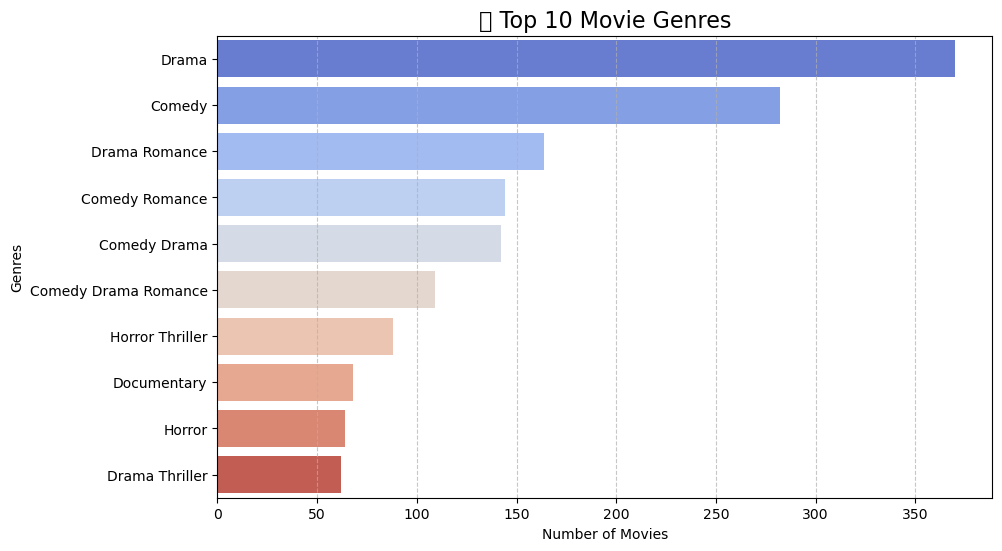

In [10]:
# Import necessary libraries (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the 'genres' column for plotting
genre_exploded = movies_data.copy()
genre_exploded['genres'] = genre_exploded['genres'].str.split('|')
genre_exploded = genre_exploded.explode('genres')

# Plot the top 10 genres
plt.figure(figsize=(10,6))
sns.countplot(y=genre_exploded['genres'],
              order=genre_exploded['genres'].value_counts().index[:10],
              palette='coolwarm')

plt.title("🎬 Top 10 Movie Genres", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## 🔑 Top 10 Movie Keywords

This chart displays the 10 most frequent keywords associated with movies.  
Keywords describe movie themes or elements like *hero*, *magic*, *friendship*, etc.  
We split the `keywords` field and used `countplot` to visualize their popularity.


C:\Users\daaim\AppData\Local\Temp\ipykernel_14384\3688544096.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=keywords_exploded['keywords'],
C:\Users\daaim\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


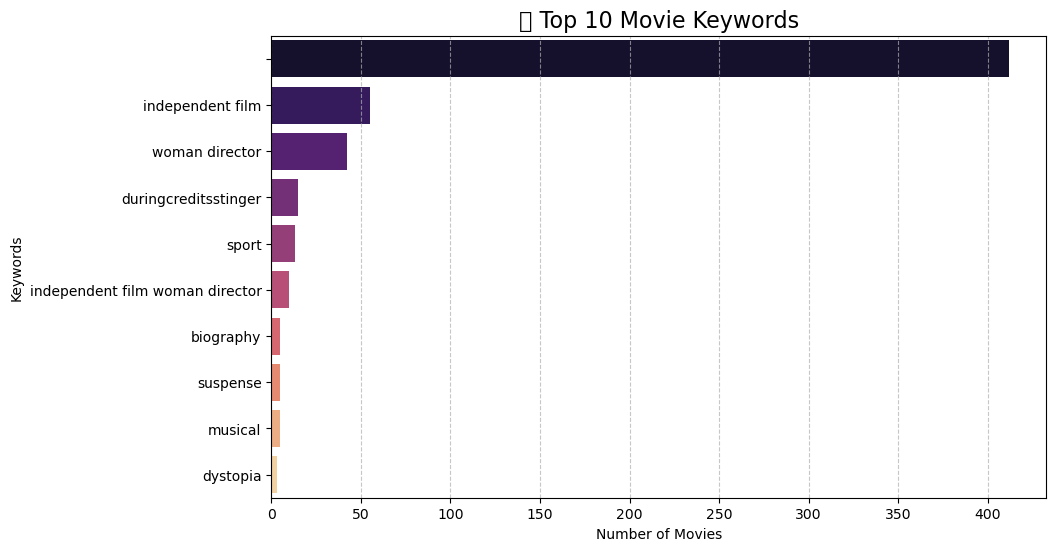

In [11]:
# Handle missing values
movies_data['keywords'] = movies_data['keywords'].fillna('')

# Explode keywords
keywords_exploded = movies_data.copy()
keywords_exploded['keywords'] = keywords_exploded['keywords'].str.split('|')
keywords_exploded = keywords_exploded.explode('keywords')

# Plot top 10 keywords
plt.figure(figsize=(10,6))
sns.countplot(y=keywords_exploded['keywords'],
              order=keywords_exploded['keywords'].value_counts().index[:10],
              palette='magma')

plt.title("🔑 Top 10 Movie Keywords", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Keywords")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
